# multiscale model fitting for Toy2a

Toy2a is a simplified version of toy2

### start with initalizing many things

In [4]:
# imports
import os
# import sys
import torch
# import pickle
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
# import time
import math

# module_path = os.path.abspath(os.path.join('../src/'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
    
# import torch_cae_multilevel_V4 as net
import ResNet as tnet
# import utils

In [117]:
# paths
data_dir = '../data/toy2a'
model_dir = '.'#'../models/toy2a'
result_dir = '../result/toy2a'

#load data
train_data = torch.tensor(np.load(os.path.join(data_dir, 'train_data.npy')))
val_data = torch.tensor(np.load(os.path.join(data_dir, 'val_data.npy')))
test_data = torch.tensor(np.load(os.path.join(data_dir, 'test_data.npy')))

data_of_sizes = {}
current_size = 2
unresolved_dict = {}
model_keep = list()
model_used_dict = {}


In [6]:
#testing dataset new structure
dt = 1
step_size = 32
n_forward = 5
dataset = tnet.DataSet(torch.flatten(train_data,2,3), torch.flatten(val_data,2,3), torch.flatten(test_data,2,3), dt, step_size, n_forward)

step_size =  32
x_end_idx =  33
y_start_idx =  64
y_end_idx =  225
range(0, 33, 32)
self.train_x shape =  torch.Size([100, 128])
train_ys shape =  torch.Size([100, 6, 64])


In [7]:
print(dataset.train_ys.shape)

torch.Size([100, 6, 64])


In [8]:
#functions, will move these to a utils file eventually 
#====================================================================================
# def data_of_size(data,size):
#     """
#     Takes averages to shrink size of data
#     Takes data of size (n_points, dim, dim) and shrinks to size (n_points, size, size)
#     takes averages to shrink
#     """
#     return decrease_to_size(torch.tensor(data).unsqueeze(1), size)[:,0,:,:]
#====================================================================================


def isPowerOfTwo(n):
    """
    checks if n is a power of two
    
    input: n, int
    
    output: boolean
    """
    return (np.ceil(np.log2(n)) == np.floor(np.log2(n)));
#====================================================================================
def shrink(data, low_dim):
    '''
    Shrinks data to certain size; either averages or takes endpoints
    
    inputs:
        data: array of size (n_points, n_timesteps, dim, dim) that will shrink
        low_dim: int, size to shrink to, low_dim must be less than or equal to dim
        
    output:
        data: array of size (n_points, n_timesteps, low_dim, low_dim)
    '''
    
    #check inputs
    assert len(data.shape) == 4
    n_points, n_timesteps, dim, _ = data.shape
    assert dim >= low_dim
    assert isPowerOfTwo(low_dim)
    
    if dim == low_dim: #same size, no change
        return data
    
    while(dim > low_dim):
        #shrink by 1 level until same size
        data = apply_local_op(data.float(), 'cpu', ave=average)
        current_size = data.shape[-1]
        
    return data
#====================================================================================
def ave_one_level(data):
    '''
    takes averages to shrink data 1 level
    
    inputs:
        data: tensor of size (n_points, n_timesteps, dim, dim) that will shrink
        
    output:
        processed data: tensor of size (n_points, n_timesteps, dim/2, dim/2)
    '''
    device = 'cpu'
    if not torch.is_tensor(data): #needs to be a tensor
        data = torch.tensor(data)
        
    assert len(data.shape) == 4
#     if data.shape != 4:
#         print("data.shape = ", data.shape)
#         print("data.shape should be of length 4")
    n_points, n_timesteps, dim, _ = data.shape
    
    #dim needs to be even 
    assert dim % 2 == 0
    
    data_right_size = torch.flatten(data, 0,1).unsqueeze(1).float()
    
#     n = min(in_channels, out_channels)
    op = torch.nn.Conv2d(1, 1, 2, stride=2, padding=0).to(device)
   
    op.weight.data = torch.zeros(op.weight.data.size()).to(device)
    op.bias.data = torch.zeros(op.bias.data.size()).to(device)
    op.weight.data[0,0, :, :] = torch.ones(op.weight.data[0,0, :, :].size()).to(device) / 4

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False
        
    print("Transforming")
        
    shrunk = op(data_right_size)
    
    print("reshape to print")
    
    return shrunk.squeeze(1).reshape((n_points, n_timesteps, dim//2, dim//2))



In [9]:
# print(train_data.shape)
# processed = ave_one_level(train_data)
# print(processed.shape)

In [10]:

#make a dictionary with train data of every size 128->1
#====================================================================================

def make_dict_all_sizes(data):
    """
    Makes a dictionary of data at every refinedment size from current->1
    
    inputs:
        data: tensor(or array) of size (n_points, n_timesteps, dim, dim)
        
    outputs: 
        dic: dictionary of tensors. Keys are dim size, tensors are size (n_points, n_timesteps, dim, dim)
    
    """
    
    n_points, n_timesteps, dim, _ = data.shape
    
    if not torch.is_tensor(data): #needs to be a tensor
        data = torch.tensor(data)
        
    assert isPowerOfTwo(dim)
        
    dic = {str(dim): data}
    
    for i in range(int(np.log2(dim))):
        #decrease
        print("i = ", i)
        data = ave_one_level(data)
        dic[str(data.shape[-1])] = data
    
    print(dic.keys())
    
    return dic
#====================================================================================


In [11]:
train_dict = make_dict_all_sizes(train_data)
val_dict = make_dict_all_sizes(val_data)

i =  0
Transforming
reshape to print
i =  1
Transforming
reshape to print
i =  2
Transforming
reshape to print
dict_keys(['8', '4', '2', '1'])
i =  0
Transforming
reshape to print
i =  1
Transforming
reshape to print
i =  2
Transforming
reshape to print
dict_keys(['8', '4', '2', '1'])


In [12]:
train_x = train_dict['1'][0,:-1,0]
print(train_x.shape)
train_y = train_dict['1'][0,1:,0]
print(train_y.shape)


torch.Size([499, 1])
torch.Size([499, 1])


In [64]:
%load_ext autoreload
%autoreload 2

using new ResNet thing
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
def form_data(data, step_size = 1):
    """
    Forms data to input to network. 
    
    inputs:
        data: torch. shape, (n_points, n_timesteps, 1, 1)
        step_size: int
        
    outputs:
        inputs, torch shape (max_points, 3)
        outputs, torch shape (max_points, 1)
    """
    print("data shape = ", data.shape)
    train_data = data[:,::step_size]
    inputs = torch.cat((train_data[:,:-3,0], train_data[:,1:-2,0], train_data[:,2:-1,0]), axis = 2)
    inputs = torch.flatten(inputs, end_dim=1)
    outputs = train_data[:,3:,0]
    outputs = torch.flatten(outputs, end_dim=1)
    
    return inputs, outputs
    

In [192]:
import ResNet as tnet
#====================================================================================
def train_one_timestep(step_size, train_data, val_data=None, test_data=None, current_size=1, 
                       dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = True, 
                       lr = 1e-3, max_epochs = 10000, batch_size = 50,threshold = 1e-4, 
                       model_dir = './models/toy2a',i=None, j = None,print_every=1000):

    """
    fits or loads model at 1 timestep
    
    inputs:
        step_size: int 
        train_data: tensor size (n_points, n_timesteps, dim**2) 
        val_data:tensor size (n_val_points, n_timesteps, dim**2) 
        test_data:tensor size (n_test_points, n_timesteps, dim**2) 
        current_size: int, only used in file naming
        dt = 1: float
        n_forward = 5: int, number of steps to consider during training
        noise=0: float, level of noise, (right now just used in file naming)
        make_new = False: boolean, whether or not to make a new model if old already exists
        dont_train = True: boolean, whether or not to train more if model loaded
        lr = 1e-3: float, learning rate
        max_epochs = 10000: int 
        batch_size = 50: int
        threshold=1e-4: float, stop training when validation gets below threshold
         
    
    outputs:
        model_time: ResNet object of trained model. Also saved
    """
    print("inside train_one_timestep")
    if (i is not None) and (j is not None):
        model_name = 'model_L{}_D{}_noise{}_i{}_j{}.pt'.format(current_size,step_size, noise, i, j)
    else:
        model_name = 'model_L{}_D{}_noise{}.pt'.format(current_size,step_size, noise)
    model_path_this = os.path.join(model_dir, model_name)
    
#     n_points, n_timesteps, total_dim = train_data.shape
#     arch = [total_dim, 128, 128, 128, total_dim] 
    
    try: #if we already have a model saved
        if make_new:
            print("Making a new model. Old one deleted. model {}".format(model_name))
            assert False
        model_time = torch.load(model_path_this)
        print("model loaded: ", model_name)
        print("don't train = ", dont_train)
        if dont_train: #just load model, no training
            return model_time
    except:
        print('create model {} ...'.format(model_name))
        model_time = tnet.ResNet(train_data,val_data,step_size, model_name=model_name)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model_time.parameters())

    model_time.train_model(optimizer, criterion)
    
    return model_time


using new ResNet thing


In [80]:
step_size = 32
model_time = train_one_timestep(step_size, train_dict['1'], val_dict['1'])

inside train_one_timestep
create model model_L1_D32_noise0.pt ...
data shape =  torch.Size([100, 500, 1, 1])
data shape =  torch.Size([10, 500, 1, 1])


NameError: name 'val_input' is not defined

<ipython-input-81-6cdaa836ad83>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_first = torch.tensor(inputs[:-1])


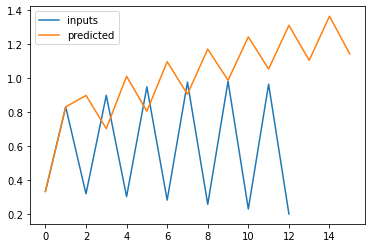

In [81]:
# print(torch.tensor(x[0:1]).unsqueeze(1))
# inputs = np.zeros((498, 2))
# inputs = torch.cat((train_dict['1'][0,:-2,0], train_dict['1'][0,1:-1,0]), axis = 1)
data_smaller = train_dict['1'][:,::step_size]
i = 3
inputs = torch.cat((data_smaller[i,:-3,0], data_smaller[i,1:-2,0], data_smaller[i,2:-1,0]), axis = 1)
outputs = data_smaller[i,3:,0]
# inputs = inputs[::step_size]
# outputs = outputs[::4]
    
# inputs = train_dict['1'][0,:-1,0]
# outputs = train_dict['1'][0,2:,0]
inputs_first = torch.tensor(inputs[:-1])
plt.plot(inputs[:,0], label = "inputs")
# plt.plot(outputs[:,0], label = "outputs")#,'--bo')
t = 0
y_pred = model_time(inputs_first[0:3].float())
y_pred = torch.cat((inputs_first[0:3,0:2].float(),y_pred), axis = 1)
to_plot = [y_pred.detach().numpy()[0,0]]
# plt.plot(t,y_pred.detach().numpy()[0,0],'.')
for i in range(int(498/step_size)):
    y_next = model_time(y_pred)
    y_next = torch.cat((y_pred[:, 1:3],y_next), axis = 1)
    to_plot.append(y_next.detach().numpy()[0,0])
#     plt.plot(i + 2, y_next.detach().numpy()[0,0],'.')
    y_pred = y_next
plt.plot(to_plot, label = "predicted")
plt.legend()
    
    

In [221]:

#====================================================================================

def find_best_timestep(train_data, val_data, test_data, current_size, start_k = 0, largest_k = 7, 
                       dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = True,
                       lr = 1e-3, max_epochs = 10000, batch_size = 50,threshold = 1e-4, 
                       criterion = torch.nn.MSELoss(reduction='none'), model_dir = "./models/toy2",
                       i=None, j = None,print_every= 1000):
    """
    Trains models with different timestep sizes and finds lowest error
    
    inputs:
     n_forward = 5, noise=0, make_new = False, dont_train = False):
    
        train_data: tensor size (n_points, n_timesteps, dim, dim), or  size (n_points, n_timesteps)
        val_data:tensor size (n_val_points, n_timesteps, dim, dim) , or  size (n_val_points, n_timesteps)
        test_data:tensor size (n_test_points, n_timesteps, dim, dim) , or  size (n_test_points, n_timesteps)
        current_size: int, only used in file naming
        start_k = 0: int, smallest timestep will be 2**start_k
        largest_k = 7:int, largest timestep will be 2**largest_k
        dt = 1: float
        n_forward = 5: int, number of steps to consider during training
        noise=0: float, level of noise, (right now just used in file naming)
        make_new = False: boolean, whether or not to make a new model if old already exists
        dont_train = False: boolean, whether or not to train more if model loaded
        lr = 1e-3: float, learning rate
        max_epochs = 10000: int 
        batch_size = 50: int
        threshold=1e-4: float
        criterion = torch.nn.MSELoss(reduction='none'))
         
         
    outputs:
        models: list of ResNet models
        step_sizes: list of ints for the steps_sizes of models 
        mse_list: list of floats, mse of models 
        idx_lowest: int, index value with lowest mse
         
    """
    
    
    #transform data shapes if needed
    if(len(train_data.shape)== 2):
        train_data = train_data.unsqueeze(2).unsqueeze(3)
        val_data = val_data.unsqueeze(2).unsqueeze(3)
        test_data = test_data.unsqueeze(2).unsqueeze(3)
    assert(len(train_data.shape)== 4)
    assert(len(val_data.shape)== 4)
    assert(len(test_data.shape)== 4)
    
    models = list()
    step_sizes = list()
    n_forward_list = list()
    mse_lowest = 1e10 #big number
    mse_list = list()
    mse_less = 0
    idx_lowest = -1
    
    #make data flat to right dim (n_points, n_timesteps, dim**2)
#     train_data = torch.flatten(train_data, 2,3)
#     val_data = torch.flatten(val_data, 2,3)
#     test_data = torch.flatten(test_data, 2,3)
    
    n_points, n_timesteps, _,_ = train_data.shape
    
    
    for idx, k in enumerate(range(start_k, largest_k)):
        step_size = 2**k
        step_sizes.append(step_size)
        
#         model_time = train_one_timestep(step_size, train_data, val_data, test_data, current_size, 
#                                         make_new = make_new, dont_train = dont_train,i=i, j=j, 
#                                         n_forward=n_forward, max_epochs=max_epochs,model_dir=model_dir, print_every = print_every)
        
        model_time = train_one_timestep(step_size, train_data, val_data,model_dir=model_dir, make_new=make_new)
#         return model_time
        models.append(model_time)
    
        #find error

#         x_init = model[0:3].float()
        print("val_data shape =", val_data.shape)

        pred, mse = model_time.predict_mse()
#         y_preds = model_time.uni_scale_forecast(val_data[:,0,0].float(), n_steps=n_timesteps-1)
#         mse_all = criterion(val_data[:, 1:, :].float(), y_preds).mean(-1)

#         mean = mse_all.mean(0).detach().numpy()
# #         print(mean.shape)
#         mse_less = mean.mean()
        mse_list.append(mse)

#         print("mse_lowest = ", mse_lowest)
#         print("mse_less= ", mse_less)
        
        if (mse < mse_lowest) or (math.isnan(mse_lowest)) or (math.isnan(mse)):
            mse_lowest = mse
            idx_lowest = idx

    return models, step_sizes, mse_list, idx_lowest, n_forward_list
#====================================================================================


In [231]:
import ResNet as tnet
current_size = 1
print(train_dict[str(current_size)].shape)
models, step_sizes, mse_list, idx_lowest,n_forward_list = find_best_timestep(train_dict[str(current_size)], 
                                                              val_dict[str(current_size)], 
                                                              val_dict[str(current_size)], current_size,model_dir=model_dir,# make_new=True, #print_every=100, 
                                                             start_k=2, largest_k = 6)#, dont_train = False)

using new ResNet thing
torch.Size([100, 500, 1, 1])
inside train_one_timestep
model loaded:  model_L1_D4_noise0.pt
don't train =  True
val_data shape = torch.Size([10, 500, 1, 1])
inside train_one_timestep
model loaded:  model_L1_D8_noise0.pt
don't train =  True
val_data shape = torch.Size([10, 500, 1, 1])
inside train_one_timestep
model loaded:  model_L1_D16_noise0.pt
don't train =  True
val_data shape = torch.Size([10, 500, 1, 1])
inside train_one_timestep
model loaded:  model_L1_D32_noise0.pt
don't train =  True
val_data shape = torch.Size([10, 500, 1, 1])


In [224]:
print(mse_list, idx_lowest)

[0.1908808968961239, 0.04034204150084406, 0.0929533451795578, 0.20230200410733232] 1


<ipython-input-227-937f9de73deb>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_first = torch.tensor(inputs[:-1])


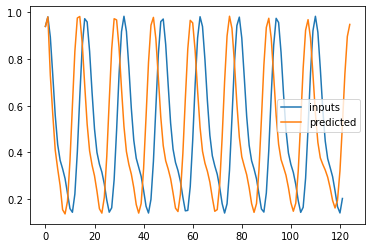

In [227]:
def pred_n_plot(data, model):# print(torch.tensor(x[0:1]).unsqueeze(1))
# inputs = np.zeros((498, 2))
# inputs = torch.cat((train_dict['1'][0,:-2,0], train_dict['1'][0,1:-1,0]), axis = 1)
    data_smaller = data[:,::step_size]
    i = 2
    inputs = torch.cat((data_smaller[i,:-3,0], data_smaller[i,1:-2,0], data_smaller[i,2:-1,0]), axis = 1)
    outputs = data_smaller[i,3:,0]
    # inputs = inputs[::step_size]
    # outputs = outputs[::4]

    # inputs = train_dict['1'][0,:-1,0]
    # outputs = train_dict['1'][0,2:,0]
    inputs_first = torch.tensor(inputs[:-1])
    plt.plot(inputs[:,0], label = "inputs")
    # plt.plot(outputs[:,0], label = "outputs")#,'--bo')
    t = 0
    y_pred = model_time(inputs_first[0:3].float())
    y_pred = torch.cat((inputs_first[0:3,0:2].float(),y_pred), axis = 1)
    to_plot = [y_pred.detach().numpy()[0,0]]
    # plt.plot(t,y_pred.detach().numpy()[0,0],'.')
    for i in range(int(498/step_size)):
        y_next = model_time(y_pred)
        y_next = torch.cat((y_pred[:, 1:3],y_next), axis = 1)
        to_plot.append(y_next.detach().numpy()[0,0])
    #     plt.plot(i + 2, y_next.detach().numpy()[0,0],'.')
        y_pred = y_next
    plt.plot(to_plot, label = "predicted")
    plt.legend()
    
# model_time = torch.load('./model_L1_D4_noise0.pt')
pred_n_plot(val_dict[str(current_size)], models[idx_lowest]) 
# pred = model_time.predict_mse()

125
torch.Size([1220, 3])


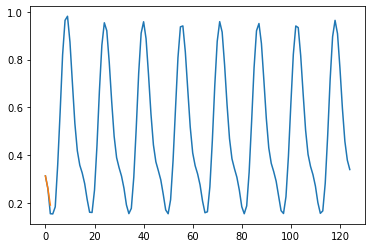

In [ ]:
# #plot a bunch
# # 
# step_size = 4
# dt =1
# n_forward = int(500/step_size - 1)
# model_name = 'model_L{}_D{}_noise{}.pt'.format(current_size,step_size, 0)
# model_path_this = os.path.join(model_dir, model_name)

# n_points, n_timesteps, total_dim = torch.flatten(train_dict[str(current_size)], 2,3).shape
# arch = [total_dim, 128, 128, 128, total_dim] 


# model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# dataset = tnet.DataSet(torch.flatten(train_dict[str(current_size)], 2,3), torch.flatten(val_dict[str(current_size)], 2,3), 
#                        torch.flatten(val_dict[str(current_size)], 2,3), dt, step_size, n_forward)

# #plot the inputed data
# plt.figure()
# plt.plot(dataset.val_ys[0, :, 0])#, '.')
# #     plt.plot(np.arange(len(dataset.val_ys[point_num, :, i]))*dataset.step_size, dataset.val_ys[point_num, :, i], '.')
# #     plt.plot(torch.flatten(val_data, 2,3)[0,s_size:,0])
# plt.title('step size = '+str(step_size)+" start")
# #   plt.xlim([0,100])
# plt.show()

# # training
# for i in range(10):
#     model_time.train_net(dataset, batch_size = 32, max_epoch=10,model_path=model_path_this)
#     models = list()
#     models.append(model_time)
#     plt.figure()
# #     plt.plot(dataset.val_ys[0, :, 0])
#     predicted = tnet.multi_scale_forecast(dataset.val_ys[:,0,:],n_forward, models)
#     plt.plot(dataset.val_ys[0,:,0], '.')
#     plt.plot(predicted[0,:,0])
#     plt.title('i = '+str(i))
#     #   plt.xlim([0,100])
#     plt.show()

# # return model_time

8
[4, 8, 16, 32] [0.1908808968961239, 0.03998032197996508, 0.09305808898061514, 0.19574224875541404]
shape =  (10, 60)
10


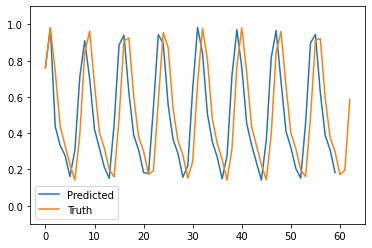

In [253]:
import ResNet as tnet
#====================================================================================
def plot_lowest_error(data, model, i = 0):
    """
    Plot data at model, idx
    
    inputs:
        data: tensor of shape (n_points, n_timesteps, dim, dim)
        model: Resnet model to predict on 
        i: int, which validation point to graph
    outputs:
        No returned values, but graph shown
    
    
    """
    data  = torch.flatten(data, 2,3)
    _, total_steps, _ = data.shape
#     y_preds = model.uni_scale_forecast(torch.tensor(data[:,0,:]).float(), n_steps=total_steps-1)
    y_preds, mse = model.predict_mse()
    print("shape = ", y_preds.shape)
    print(len(y_preds))
    plt.plot(y_preds[i], label = "Predicted")
    plt.plot(model.val_data[i,::model.step_size,0,0], label = "Truth")
    plt.ylim([-.1, 1.1])
    plt.legend()
    plt.show()
#====================================================================================

print(step_sizes[idx_lowest])    
print(step_sizes, mse_list)
plot_lowest_error(val_dict[str(current_size)], models[idx_lowest], i =2)

# print(train_data.shape)
# dataset = tnet.DataSet(torch.flatten(train_data, 2,3), torch.flatten(val_data, 2,3), 
#                        torch.flatten(val_data, 2,3), 1, step_sizes[idx_lowest], 5)
# dataset.plot_val_data()

In [263]:
#====================================================================================
def find_error_4(data, model, truth_data, tol = 1e-5):
    """
    Find error over the 4 squares 
    
    inputs:
        data: tensor of size (n_points, n_timesteps, dim, dim) to be predicted or size (n_points, n_timesteps)
        model: Resnet object to predict data on
        truth_data: tensor of size (n_points, n_timesteps, dim_larger, dim_larger) compared on 
        tol = 1e-5: tolerance level to mark points as resolved or not
        criterion = torch.nn.MSELoss(reduction='none')
        
    outputs:
        resolved: boolean whether complete area is resolved or not
        loss: array of floats for size (dim, dim) with mse of each square
        unresolved: array of booleans, whether that part is resolved or not. (1 unresolved, 0 resolved)
    """
    if(len(data.shape))==2:
        data = data.unsqueeze(2).unsqueeze(3)
    assert len(data.shape) == 4
    n_points, n_timesteps, dim, _ = data.shape
    data  = torch.flatten(data, 2,3)
    y_preds, mse_avg = model.predict_mse()
    
#     y_preds = model.uni_scale_forecast(torch.tensor(data[:,0,:]).float(), n_steps=n_timesteps-1).reshape(( n_points, n_timesteps-1, dim,dim))
    
    _,_, truth_dim, _ = truth_data.shape
    assert truth_dim >= dim
    
    truth_with_step_size = truth_data[:,::model.step_size]
    
    print(y_preds.shape)
    print(truth_data[:,::model.step_size].shape)
    loss = mse(y_preds, truth_with_step_size[:,3:])
    
    resolved =  loss.max() <= tol
    unresolved_array = torch.tensor(loss <= tol)
    
    return resolved, loss, 1-unresolved_array.float()



#====================================================================================    
    
def mse(data1, data2):
    """
    Finds Mean Squared Error between data1 and data2
    
    inputs:
        data1: tensor of shape (n_points, n_timestep, dim1, dim1)
        data2: tensor of shape (n_points, n_timestep, dim2, dim2)
        
    output:
        mse: array of size (min_dim, min_dim) with mse 
    
    """
    #made 4 dims
    if len(data1.shape) != 4:
        data1 = torch.tensor(data1).unsqueeze(2).unsqueeze(3)
    if len(data2.shape) != 4:
        data2 = torch.tensor(data2).unsqueeze(2).unsqueeze(3)
        
    #need to be 4d now
    assert len(data1.shape) ==4
    assert len(data2.shape) ==4
        
    #find bigger dim
    size1 = data1.shape[-1]
    size2 = data2.shape[-1]
    print(size1, size2)
    size_max = max(size1, size2)
    
    #grow to save sizes and find mse
    mse = np.mean((grow(data1, size_max) - grow(data2, size_max))**2, axis = (0, 1))
    return mse
#====================================================================================
    
def grow(data, dim_full=128):
    '''
    Grow tensor from any size to a bigger size
    inputs: 
        data: tensor to grow, size (n_points, n_timesteps, dim_small, dim_small)
        dim_full = 128: int of size to grow data to

    outputs:
        data_full: tensor size (n_points, n_timesteps, size_full, size_full)
    '''
    n_points, n_timesteps, dim_small, _ = data.shape 
    assert dim_full % dim_small == 0 #need small to be multiple of full

    divide = dim_full // dim_small

    data_full = np.zeros((n_points, n_timesteps, dim_full,dim_full))
    for i in range(dim_small):
        for j in range(dim_small):
            repeated = np.repeat(np.repeat(data[:,:,i,j].reshape(n_points,n_timesteps,1,1), divide, axis = 2), divide, axis = 3)
            data_full[:,:,i*divide:(i+1)*divide, j*divide:(j+1)*divide] = repeated
    return data_full
#====================================================================================


resolved, loss, unresolved_list = find_error_4(val_dict['1'], models[idx_lowest], val_dict['2'])
print(loss.shape)
print(loss)

(10, 60)
torch.Size([10, 63, 2, 2])
1 2
(2, 2)
[[0.20618094 0.16172121]
 [0.16172121 0.16172121]]


In [ ]:

unresolved_dict[str(current_size)] = torch.tensor(unresolved_list)

print(unresolved_list)

In [ ]:
next_train_data = unresolved_list * train_dict[str(current_size*2)]
print(next_train_data.shape)
plt.imshow(next_train_data[0,0])
plt.colorbar()
plt.show()

In [ ]:
model_keep.append(models[idx_lowest])
model_used_dict[str(current_size)] = [[0]]

In [ ]:
#====================================================================================
def find_error_1(data, model, tol = 1e-5):
    """
    Find error over the 1 square
    
    inputs:
        data: tensor of size (n_points, n_timesteps, dim, dim) to be predicted
        model: Resnet object to predict data on
        tol = 1e-5: tolerance level to mark points as resolved or not
        criterion = torch.nn.MSELoss(reduction='none')
        
    outputs:
        loss: float of mse
        resolved: boolean whether resolved or not
    """
    n_points, n_timesteps  = data.shape
    dim = 1
    data_input  = data.unsqueeze(2)
    y_preds = model.uni_scale_forecast(torch.tensor(data_input[:,0,:]).float(), n_steps=n_timesteps-1).reshape(( n_points, n_timesteps-1, dim,dim))
    data1 = data[:,1:]
    data2 = y_preds[:,:,0,0]
#     print()
    loss = torch.mean((data1-data2)**2)#mse(y_preds, data[:,1:])
    
#     print(loss)
    
    return loss, loss <= tol

#====================================================================================


current_size = 2
next_train_data = unresolved_list * train_dict[str(current_size)]

model_idx_list = np.ones((current_size, current_size))*(-1) #start with all -1

for i in range(current_size):
    for j in range(current_size):
        data_this = next_train_data[:,:,i,j]
        if (torch.min(data_this) == 0) and (torch.max(data_this) == 0):
            #don't need to do anything is model is resolved
            continue
        else:
        #see if the error is low enough on already made model
            for m, model in enumerate(model_keep):
                loss, resolved = find_error_1(data_this, model)
                step_size = model.step_size
                print("loss = ", loss)
                print("step_size = ", step_size)
                if resolved:
                    model_idx_list[i,j] == m
                    break
                else:
                    pass
            if not resolved:
                i = 0
                j = 1
                k = int(np.log2(step_size))
                print("k = ", k)
                print("train_dict[str(current_size)][:,:,i,j] shape = ", train_dict[str(current_size)][:,:,i,j].shape)
                #if no model good, train new model
                models, step_sizes, mse_list, idx_lowest = find_best_timestep(train_dict[str(current_size)][:,:,i,j], 
                                                              val_dict[str(current_size)][:,:,i,j], 
                                                              val_dict[str(current_size)][:,:,i,j], current_size,model_dir=model_dir,
                                                              i=i, j=j, start_k = max(0,k-1), largest_k = k+2)
                
                vbnm
                resolved, loss, unresolved_list = find_error_4(val_dict[str(current_size)][:,:,i,j], 
                                                               models[idx_lowest], 
                                                               val_dict[str(current_size)][:,:, i*current_size:(i+1)*current_size, j*current_size:(j+1)*current_size])
                model_keep.append(models[idx_lowest])
                model_idx_list[i,j] == len(model_keep) #last model will be the one for this square
            
#             predicted = model.uni_scale_forecast(torch.tensor(data[:,0,:]).float(), n_steps=n_timesteps-1).reshape((  n_points, n_timesteps-1, dim,dim))

In [ ]:
print(step_sizes, mse_list, idx_lowest)
resolved, loss, unresolved_list = find_error_4(val_dict[str(current_size)][:,:,i,j], 
                                                               models[idx_lowest], 
                                                               val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, j*current_size:(j+1)*current_size])
print(loss)    

In [ ]:
model =  models[idx_lowest]
print(idx_lowest)
n_timesteps = 500
n_points = 10
dim = 1
# plt.plot(model(val_dict[str(current_size)][:,:,i,j].unsqueeze(2).unsqueeze(3))[0,:,0,0].detach().numpy(), label = "predicted")
print(val_dict[str(current_size)][:,0,i,j].unsqueeze(1).shape)
val_data_this = val_dict[str(current_size)][:,0,i,j].unsqueeze(1)
predicted = model.uni_scale_forecast(val_data_this, n_steps=n_timesteps-1)
print(predicted.shape)
predicted_reshape = predicted.reshape((  n_points, n_timesteps-1, dim,dim))
plt.plot(predicted_reshape[0,:,0], label = "predicted")
print(val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size].shape)
# plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,0], label = "Truth")

plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,1], label = "Truth")
plt.legend()

In [ ]:
plt.imshow(val_dict[str(current_size*2)][0,0])
plt.colorbar()

In [ ]:
step_size = (16+32)/2
print(step_size)
model = train_one_timestep(int(28), train_dict[str(current_size)][:,:,i,j].unsqueeze(2), 
                           val_dict[str(current_size)][:,:,i,j].unsqueeze(2), 
                           val_dict[str(current_size)][:,:,i,j].unsqueeze(2), current_size)
#                        dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = True, 
#                        lr = 1e-3, max_epochs = 10000, batch_size = 50,threshold = 1e-4, 
#                        model_dir = './models/toy2',i=None, j = None):
    
#     train_dict[str(current_size)][:,:,i,j], 
#                                                               val_dict[str(current_size)][:,:,i,j], 
#                                                               val_dict[str(current_size)][:,:,i,j], current_size,model_dir=model_dir, 
#                                                               i=i, j=j, start_k = max(0,k-1), largest_k = k+2)

In [ ]:
i = 0
j = 1
resolved, loss, unresolved_list = find_error_4(val_dict[str(current_size)][:,:,i,j], 
                                                               model, 
                                                               val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, j*current_size:(j+1)*current_size])
print(loss)

In [ ]:
# model =  models[idx_lowest]
print(idx_lowest)
n_timesteps = 500
n_points = 10
dim = 1
# plt.plot(model(val_dict[str(current_size)][:,:,i,j].unsqueeze(2).unsqueeze(3))[0,:,0,0].detach().numpy(), label = "predicted")
print(val_dict[str(current_size)][:,0,i,j].unsqueeze(1).shape)
val_data_this = val_dict[str(current_size)][:,0,i,j].unsqueeze(1)
predicted = model.uni_scale_forecast(val_data_this, n_steps=n_timesteps-1)
print(predicted.shape)
predicted_reshape = predicted.reshape((  n_points, n_timesteps-1, dim,dim))
plt.plot(predicted_reshape[0,:,0], label = "predicted")
print(val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size].shape)
# plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,0], label = "Truth")

plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,1], label = "Truth")
plt.legend()